In [1]:
import os
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/BayArea_GIS')

medium_duty_class = [3, 4, 5, 6] # ref: https://afdc.energy.gov/data/10380
heavy_duty_class = [7, 8]

plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

In [2]:
registration_data = read_csv('registration/CA_MDHDbybizID.csv')
registration_data.loc[:, 'MDV'] = registration_data.loc[:, 'totcount'] * (registration_data.loc[:, 'vin_gvw'].isin(medium_duty_class)) + \
0 * (registration_data.loc[:, 'vin_gvw'].isin(heavy_duty_class))
registration_data.loc[:, 'HDV'] = 0 * (registration_data.loc[:, 'vin_gvw'].isin(medium_duty_class)) + \
registration_data.loc[:, 'totcount'] * (registration_data.loc[:, 'vin_gvw'].isin(heavy_duty_class))
print(registration_data.totcount.sum())
registration_data.head(5)

890077


,Unnamed: 0,zip_code,vocation,carrier_type,business_name,fuel,vin_gvw,vehicle_type,yr_mdl,totcount,MDV,HDV
0,1,90001,AGRICULTURE/FARM,PRIVATE,121048.0,DIESEL,7,STRAIGHT TRUCK,1995,1,0,1
1,2,90001,AGRICULTURE/FARM,PRIVATE,121048.0,DIESEL,8,TRACTOR TRUCK,1996,1,0,1
2,3,90001,BEVERAGE PROCESSING & DISTRIBUTION,PRIVATE,14652.0,DIESEL,7,CAB CHASSIS,1991,1,0,1
3,4,90001,BUS TRANSPORTATION,FOR HIRE,7289.0,DIESEL,8,BUS NON SCHOOL,1999,1,0,1
4,5,90001,BUS TRANSPORTATION,FOR HIRE,38589.0,DIESEL,8,BUS NON SCHOOL,1994,1,0,1


In [3]:
count_by_carrier_type = registration_data.groupby(['carrier_type'])[['totcount']].sum()
count_by_carrier_type = count_by_carrier_type.reset_index()
count_by_carrier_type.loc[:, 'percentage'] = count_by_carrier_type.loc[:, 'totcount'] / \
count_by_carrier_type.loc[:, 'totcount'].sum() *100
print(count_by_carrier_type)

count_by_fuel_type = registration_data.groupby(['fuel'])[['totcount']].sum()
count_by_fuel_type = count_by_fuel_type.reset_index()
count_by_fuel_type.loc[:, 'percentage'] = count_by_fuel_type.loc[:, 'totcount'] / \
count_by_fuel_type.loc[:, 'totcount'].sum() *100
print(count_by_fuel_type)

                    carrier_type  totcount  percentage
0            CANADIAN GOVERNMENT         4    0.000449
1                         DEALER      7746    0.870262
2                  FINANCE LEASE     16536    1.857817
3                       FOR HIRE    108567   12.197484
4             FULL SERVICE LEASE     31202    3.505539
5                     INDIVIDUAL    332083   37.309469
6   LOCAL GOVERNMENT (U.S. ONLY)     44876    5.041811
7   MANUFACTURER SPONSORED LEASE      1059    0.118978
8                        PRIVATE    331136   37.203073
9   STATE GOVERNMENT (U.S. ONLY)      4881    0.548380
10               U.S. GOVERNMENT      1009    0.113361
11      UTILITIES/COMMUNICATIONS     10769    1.209895
12          VEHICLE MANUFACTURER       209    0.023481
                      fuel  totcount  percentage
0   COMPRESSED NATURAL GAS     12184    1.368870
1              CONVERTIBLE       214    0.024043
2                   DIESEL    678474   76.226439
3                 ELECTRIC        

total private carriers  221564
total private trucks  331136
max private trucks in a firm 9567
avg. private trucks in a firm 3.920820107073483


Text(0.5, 1.0, 'private truck count distribution')

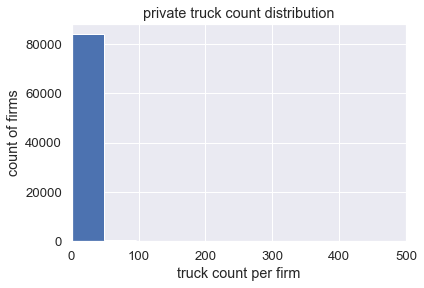

In [5]:
# private truck analysis
private_carriers = registration_data.loc[registration_data['carrier_type'] == 'PRIVATE']
private_truck_by_firm = private_carriers.groupby(['business_name'])[['totcount', 'MDV', 'HDV']].sum()
private_truck_by_firm = private_truck_by_firm.reset_index()
print('total private carriers ', len(private_carriers))
print('total private trucks ', private_carriers['totcount'].sum())
print('max private trucks in a firm', private_truck_by_firm['totcount'].max())
print('avg. private trucks in a firm', private_truck_by_firm['totcount'].mean())

private_truck_by_firm['totcount'].hist(bins = 200)
plt.xlim([0, 500])
plt.xlabel('truck count per firm')
plt.ylabel('count of firms')
plt.title('private truck count distribution')

In [6]:
size_interval = [-1, 2, 5, 10, 50, 100, 1000, private_truck_by_firm['totcount'].max()]
interval_name = ['0-2', '3-5', '6-10', '11-50', '51-100', '101-1000', '>1000']    
private_truck_by_firm.loc[:, 'size_group'] = pd.cut(private_truck_by_firm['totcount'], 
                                                bins = size_interval, right = True, 
                                                labels = interval_name)
# private_truck_by_firm.head(5)
truck_count_by_size = private_truck_by_firm.groupby('size_group').agg({'business_name': 'count',
                                                                   'totcount': ['sum','std'],
                                                                   'MDV': 'sum',
                                                                   'HDV': 'sum'})
truck_count_by_size = truck_count_by_size.reset_index()
truck_count_by_size.columns = ['fleet_size', 'total_carriers', 'total_trucks', 'total_truck_std',
                               'total_single_trucks', 'total_combination_trucks']
print(truck_count_by_size.head(5))


  fleet_size  total_carriers  total_trucks  total_truck_std  \
0        0-2           62818         75609         0.402693   
1        3-5           12108         44643         0.779756   
2       6-10            5113         38209         1.363688   
3      11-50            3842         74861         8.951308   
4     51-100             326         22584        13.511152   

   total_single_trucks  total_combination_trucks  
0                48815                     26794  
1                24624                     20019  
2                18655                     19554  
3                32084                     42777  
4                 8381                     14203  


In [7]:
min_size_lookup = {'0-2':1, '3-5':3, '6-10':6, 
                   '11-50':11, '51-100':51, '101-1000':101, 
                   '>1000':1001}
truck_count_by_size.loc[:, 'min_size'] = truck_count_by_size.loc[:, 'fleet_size'].map(min_size_lookup)
truck_count_by_size.loc[:, 'avg_truck_per_carrier'] = truck_count_by_size.loc[:, 'total_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'avg_sut_per_carrier'] = truck_count_by_size.loc[:, 'total_single_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'avg_ct_per_carrier'] = truck_count_by_size.loc[:, 'total_combination_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'fraction_of_carrier'] = truck_count_by_size.loc[:, 'total_carriers'] / truck_count_by_size.loc[:, 'total_carriers'].sum()
truck_count_by_size.loc[:, 'percent_sut'] = truck_count_by_size.loc[:, 'total_single_trucks'] / truck_count_by_size.loc[:, 'total_trucks']
truck_count_by_size.to_csv('registration/CA_private_fleet_size_distribution.csv', index = False, sep = ',')

total for-hire carriers  63672
total for-hire trucks  108551
max for-hire trucks in a firm 1397
avg. for-hire trucks in a firm 4.1038524063362445


Text(0.5, 1.0, 'for-hire truck count distribution')

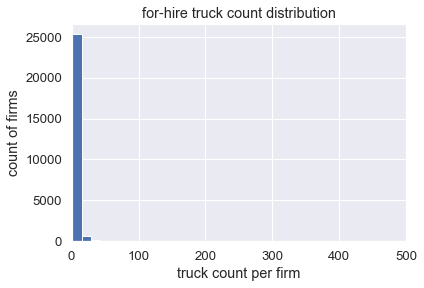

In [9]:
# for-hire truck analysis
for_hire_carriers = registration_data.loc[registration_data['carrier_type'] == 'FOR HIRE']
print('total for-hire carriers ', len(for_hire_carriers))

for_hire_truck_by_firm = for_hire_carriers.groupby(['business_name'])[['totcount', 'MDV', 'HDV']].sum()
for_hire_truck_by_firm = for_hire_truck_by_firm.reset_index()
print('total for-hire trucks ', for_hire_truck_by_firm['totcount'].sum())
print('max for-hire trucks in a firm', for_hire_truck_by_firm['totcount'].max())
print('avg. for-hire trucks in a firm', for_hire_truck_by_firm['totcount'].mean())

for_hire_truck_by_firm['totcount'].hist(bins = 100)
plt.xlim([0, 500])
plt.xlabel('truck count per firm')
plt.ylabel('count of firms')
plt.title('for-hire truck count distribution')

In [10]:
size_interval = [-1, 2, 5, 10, 50, 100, 1000, for_hire_truck_by_firm['totcount'].max()]
interval_name = ['0-2', '3-5', '6-10', '11-50', '51-100', '101-1000', '>1000']    
for_hire_truck_by_firm.loc[:, 'size_group'] = pd.cut(for_hire_truck_by_firm['totcount'], 
                                                bins = size_interval, right = True, 
                                                labels = interval_name)
# private_truck_by_firm.head(5)
truck_count_by_size = for_hire_truck_by_firm.groupby('size_group').agg({'business_name': 'count',
                                                                   'totcount': ['sum','std'],
                                                                   'MDV': 'sum',
                                                                   'HDV': 'sum'})
truck_count_by_size = truck_count_by_size.reset_index()
truck_count_by_size.columns = ['fleet_size', 'total_carriers', 'total_trucks', 'total_truck_std',
                               'total_single_trucks', 'total_combination_trucks']
print(truck_count_by_size.head(5))


  fleet_size  total_carriers  total_trucks  total_truck_std  \
0        0-2           19560         23627         0.405833   
1        3-5            3720         13664         0.775830   
2       6-10            1525         11560         1.412684   
3      11-50            1405         28847         9.525563   
4     51-100             158         11162        14.140368   

   total_single_trucks  total_combination_trucks  
0                 3331                     20296  
1                 2376                     11288  
2                 1893                      9667  
3                 4276                     24571  
4                 1351                      9811  


In [11]:
min_size_lookup = {'0-2':1, '3-5':3, '6-10':6, 
                   '11-50':11, '51-100':51, '101-1000':101, 
                   '>1000':1001}
truck_count_by_size.loc[:, 'min_size'] = truck_count_by_size.loc[:, 'fleet_size'].map(min_size_lookup)
truck_count_by_size.loc[:, 'avg_truck_per_carrier'] = truck_count_by_size.loc[:, 'total_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'avg_sut_per_carrier'] = truck_count_by_size.loc[:, 'total_single_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'avg_ct_per_carrier'] = truck_count_by_size.loc[:, 'total_combination_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'fraction_of_carrier'] = truck_count_by_size.loc[:, 'total_carriers'] / truck_count_by_size.loc[:, 'total_carriers'].sum()
truck_count_by_size.loc[:, 'percent_sut'] = truck_count_by_size.loc[:, 'total_single_trucks'] / truck_count_by_size.loc[:, 'total_trucks']
truck_count_by_size.to_csv('registration/CA_for_hire_fleet_size_distribution.csv', index = False, sep = ',')

total tx for-hire carriers  19758
total for-hire trucks  48783
max for-hire trucks in a firm 9903
avg. for-hire trucks in a firm 8.119673768308921


Text(0.5, 1.0, 'for-hire truck count distribution')

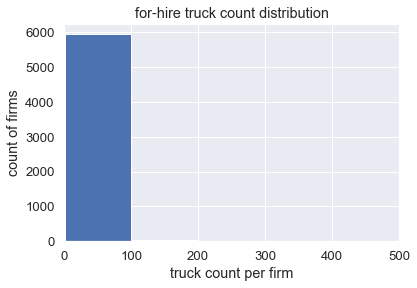

In [12]:
# for-leasing truck analysis
for_lease_carriers = registration_data.loc[registration_data['carrier_type'].isin(['FINANCE LEASE', \
                                                                                        'FULL SERVICE LEASE', \
                                                                                        'MANUFACTURER SPONSORED LEASE'])]
print('total tx for-hire carriers ', len(for_lease_carriers))

for_lease_truck_by_firm = for_lease_carriers.groupby(['business_name'])[['totcount', 'MDV', 'HDV']].sum()
for_lease_truck_by_firm = for_lease_truck_by_firm.reset_index()
print('total for-hire trucks ', for_lease_truck_by_firm['totcount'].sum())
print('max for-hire trucks in a firm', for_lease_truck_by_firm['totcount'].max())
print('avg. for-hire trucks in a firm', for_lease_truck_by_firm['totcount'].mean())

for_lease_truck_by_firm['totcount'].hist(bins = 100)
plt.xlim([0, 500])
plt.xlabel('truck count per firm')
plt.ylabel('count of firms')
plt.title('for-hire truck count distribution')

In [13]:
size_interval = [-1, 2, 5, 10, 50, 100, 1000, for_lease_truck_by_firm['totcount'].max()]
interval_name = ['0-2', '3-5', '6-10', '11-50', '51-100', '101-1000', '>1000']    
for_lease_truck_by_firm.loc[:, 'size_group'] = pd.cut(for_lease_truck_by_firm['totcount'], 
                                                bins = size_interval, right = True, 
                                                labels = interval_name)
# private_truck_by_firm.head(5)
truck_count_by_size = for_lease_truck_by_firm.groupby('size_group').agg({'business_name': 'count',
                                                                   'totcount': ['sum','std'],
                                                                   'MDV': 'sum',
                                                                   'HDV': 'sum'})
truck_count_by_size = truck_count_by_size.reset_index()
truck_count_by_size.columns = ['fleet_size', 'total_carriers', 'total_trucks', 'total_truck_std',
                               'total_single_trucks', 'total_combination_trucks']
print(truck_count_by_size.head(5))

  fleet_size  total_carriers  total_trucks  total_truck_std  \
0        0-2            4825          5326         0.305077   
1        3-5             522          1949         0.786140   
2       6-10             258          1970         1.394475   
3      11-50             293          6683        10.565402   
4     51-100              48          3390        15.018605   

   total_single_trucks  total_combination_trucks  
0                 3098                      2228  
1                  871                      1078  
2                  833                      1137  
3                 2551                      4132  
4                 1204                      2186  


In [14]:
min_size_lookup = {'0-2':1, '3-5':3, '6-10':6, 
                   '11-50':11, '51-100':51, '101-1000':101, 
                   '>1000':1001}
truck_count_by_size.loc[:, 'min_size'] = truck_count_by_size.loc[:, 'fleet_size'].map(min_size_lookup)
truck_count_by_size.loc[:, 'avg_truck_per_carrier'] = truck_count_by_size.loc[:, 'total_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'avg_sut_per_carrier'] = truck_count_by_size.loc[:, 'total_single_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'avg_ct_per_carrier'] = truck_count_by_size.loc[:, 'total_combination_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'fraction_of_carrier'] = truck_count_by_size.loc[:, 'total_carriers'] / truck_count_by_size.loc[:, 'total_carriers'].sum()
truck_count_by_size.loc[:, 'percent_sut'] = truck_count_by_size.loc[:, 'total_single_trucks'] / truck_count_by_size.loc[:, 'total_trucks']
truck_count_by_size.to_csv('registration/CA_for_lease_fleet_size_distribution.csv', index = False, sep = ',')

In [1]:
pip install tensorflow

     |████████████████████████████████| 217.4 MB 1.0 MB/s eta 0:00:012     |████████████████████████████▍   | 193.2 MB 11.1 MB/s eta 0:00:03
     |████████████████████████████████| 13.2 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 962 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB